## 5 컴퓨터 비전을 위한 딥러닝
### 5.1 합성곱 신경망 소개
#### 컨브넷의 구조 
- 컨브넷은 뇌의 시각피질이 이미지를 처리하고 인식하는 원리를 바탕으로 한 신경망입니다. 
- input Image의 픽셀과 Feature Detector의 각 kernel이 곱한 결과를 합하게 됨 그 결과가 Feature Map의 하나를 채우게 된다. 이런 과정을 Feature Dectector가 입력 이미지를 모두 훑을 떄까지 계속 됨
- Feature Map을 만들고, 원래 입력 이미지와 크기를 비교해보면 원래의 7x7 이미지가 5x5이미지로 작아진 것을 알수 있다. 다시 말해 픽셀별로 비교해도 49회 걸리던 일이 25회만 비교하면 됨 
--> 이미지 비교시 속도 up : convolution 연산의 이점 





In [ ]:
import keras 
from keras import layers
from keras import models 

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


- Conv2D와 MaxPooling2D 층의 출력은 (height, width, channels) 크기의 3D 텐서
-  채널의 수는 Conv2D 층에 전달된 첫 번째 매개변수에 의해 조절됩니다(32개 또는 64개).
-  마지막 층의 ((3, 3, 64) 크기인) 출력 텐서를 완전 연결 네트워크에 주입합니다

In [ ]:
model.add(layers.Flatten())# 영상을 일차원으로 바꿔주는 플래튼(Flatten) 레이어
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [ ]:
# MNIST 숫자 이미지에 이 컨브넷을 훈련
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 48s 52ms/step - loss: 0.9075 - accuracy: 0.6559
Epoch 2/5
938/938 [==============================] - 54s 58ms/step - loss: 0.0817 - accuracy: 0.9813
Epoch 3/5
938/938 [==============================] - 49s 52ms/step - loss: 0.0460 - accuracy: 0.9883
Epoch 4/5
938/938 [==============================] - 49s 52ms/step - loss: 0.0345 - accuracy: 0.9909
Epoch 5/5
938/938 [==============================] - 48s 52ms/step - loss: 0.0277 - accuracy: 0.9926


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 3s 9ms/step - loss: 0.0443 - accuracy: 0.9889


In [ ]:
test_acc


0.9889000058174133

#### 5.1.1 합성곱 연산 
- 완전 연결 층과 합성곱 층 사이의 근본적인 차이
: 
1. Dense 층은 입력 특성 공간에 있는 전역패턴(예를 들어 MNIST 숫자 이미지에서는 모든 픽셀에 걸친 패턴)을 학습하지만 합성곱 층은 지역 패턴을 학습함. 
ex. 이미지는 에지,질감등 지역 패턴으로 분해 가능

2. 학습된 패턴은 평행 이동 불변성을 가집니다. 
컨브넷이 이미지의 오른쪽 아래 모서리에서 어떤 패턴을 학습했다면 다른 곳에서도 이 패턴을 인식할 수 있음.
    - 완전 연결네트워크는 새로운 위치에 나타난 것은 새롭게 학습 시켜야함

3. 컨브넷은 패턴의 공간적 계층 구조를 학습할 수 있다. 
    - 첫번쨰 합성곱 층이 에지 같은 작은 지역 패턴을 학습 하고 두번째 합성곱 층은 첫번째 층의 특성으로 구성된 더 큰 패턴을 학습 
    
    : 컨브넷은 매우 복잡하고 추상적인 시각적 개념을 효과적으로 학습 가능 
    - 합성곱 연산은 특성 맵이라고 부른 3D 텐서에 적용됨
    - 이 텐서는 2개의 공간 축(높이와 너비)과 깊이 축(채널 축)으로 구성 됩니다.
    - RGB 이미지는 3개의 컬러 채널을 가지므로 깊이 축이 3이 됨
    - MNIST 숫자처럼 흑백 이미지는 깊이의 차원이 1(회색톤)입니다. 
    --> 합성곱 연산은 입력 특성 맵에서 작은 패치들을 추출하고 이런 모든 패치에 같은 변환을 적용하여 춯혁 특성 맵을 만듬
    - 출력 특성 맵도 높이와 너비를 가진 3D 텐서입니다. 출력 텐서의 깊이는 층의 매개변수로 결정되기 때문에 상황에 따라 다름 
    - 이렇게 되면 깊이 축의 채널은 더 이상 RGB 입력처럼 특정 컬러를 의미 x 그대신 필터를 의미함 
    - 필터는 입력 데이터의 어떤 특성을 인코딩 합니다. 예를 들어 고수준으로 보면 하나의 필터가 '입력에 얼굴이 있는지를 인코딩함 

MNIST 예제에서는 첫번째 합성곱 층이 (28,28,1)크기의 특성 맵을 입력으로 받아 (26,26,32)크기의 특성 맵을 출력합니다. 즉 입력에 대해 32개의 필터를 적용합니다. 32개의 출력 채널 각각은 26X26 크기의 배열 값을 가집니다. 
- 이 값은 입력에 개한 필터의 응답 맵입니다. 입력의 각 위치에서 필터 패턴에 대한 응답을 나타냄
- 특성 맵이란 ? 깊이 축에 있는 각 차원은 하나의 특성(또는 필터)아고 2D 텐서 output[:,:,n]은 입력에 대한 이필터 응답을 나타내는 2D공간상의 맵

- 합성곱의 2개의 파라미터: 입력으로부터 뽑아낼 패치의 크기, 특성 맵의 출력 깊이 
- 케라스의 Conv2D 층에서 이 파라미터는 Conv2D(output_depth,(window_height,window_width))처럼 첫번째와 두번째 매개변수로 전달됩니다. 
- 3D 입력 특성 맵 위를 3x3 또는 5x5 크기의 윈도우가 슬라이딩하면서 모든 위치에서 3D특성 패치(window_height,window_width,input_depth)크기)를 추출하는 방식으로 합성곱이 작동 
- 이런 3D 패치는 (output_depth,) 크기의 1D벡터로 변환(합성곱 커널)

- 출력 높이와 너비는 입력의 높이,너비와 다를 수 있습니다. 
    - 경계 문제, 입력 특성 맵에 패딩을 추가
    - 스트라이드의 사용 여부에 따라 다름

- 경계 문제와 패딩 이해하기
    - Conv2D 층에서 패딩은 padding 매개변수로 설정할 수 있습니다. 
    - 패딩은 이미지의 가장자리에 특정값으로 설정된 픽셀들을 추가함으로써 입력 이미지와 출력이미지의 크기를 같거나 비슷하게 만드는 역할
    - padding="valid" : 패딩 기본값, 패딩 안사용 
    - padding="same" : 입력과 동일한 높이와 너비를 가진 출력을 만들기 위해 패딩한다.
    - CNN에서는 주로 zero-padding이 이용된다
- 합성곱 스트라이드 
    - 스트라이드는 입력데이터에 필터를 적용할 때 이동할 간격을 조절하는 것, 즉 필터가 이동할 간격을 말한다.
    - 스트라이드(Stride)는 보통 1과 같이 작은 값이 더 잘 작동하며, Stride가 1일 경우 입력 데이터의 spatial 크기는 pooling 계층에서만 조절하게 할 수 있다.

#### 5.1.2 최대 풀링 연산

최대 풀링 : 대상 영역에서 최댓값을 취하는 연산
 - 풀링(Pooling) : 풀링은 2차원 데이터의 세로 및 가로 방향의 공간을 줄이는 연산이다.
 - 평균 풀링 :  대상 영역에서 평균을 계산
 - 이미지 인식 분야에서 주로 최대 풀링을 사용
 - 특징
    - 풀링 계층은 합성곱 계층과 달리 학습해야 할 매개변수가 없다. 
    - 풀링 연산은 입력 데이터의 채널 수 그대로 출력 데이터로 보낸다
    - 풀링 계층은 입력의 변화에 영향을 적게 받는다. 입력 데이터가 조금 변하더라도 풀링 계층 자체가 그 변화를 흡수하여 사라지게 한다.
 - 스트라이드 합성곱과 매우 비슷하게 강제적으로 특성 맵을 다운샘플링하는 것이 최대풀링의 역할입니다.
 - 최대 풀링은 입력 특성 맵에서 윈도우에 맞는 패치를 추출하고 각 채널별로 최댓값을 출력->  
 - 합성곱과의 차이점 :   
    - 하드 코딩된 최댓값 추출 연산을 사용
    - 스트라이드 2와 2x2윈도우 사용하여 특성 맵을 절반 크기로 다운샘플링함
    




### 5.2  소규모 데이터셋에서 컨브넷 사용하기
세 가지 전략(처음부터 작은 모델을 훈련하기, 사전 훈련된 모델을 사용해 특성 추출하기, 사전 훈련된 모델을 세밀하게 튜닝하기)
#### 5.2.1 작은 데이터셋 문제에서 딥러닝의 타당성
 - 매우 작은 이미지 데이터셋에서 어떤 종류의 특성 공학을 사용하지 않고 컨브넷을 처음부터 훈련해도 납득할 만한 결과를 만들 수 있습니다
- 거기에 더해 딥러닝 모델은 태생적으로 매우 다목적입니다.


In [ ]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls


original_train	test  trainphoto


In [ ]:
import os, shutil

In [ ]:
import os
os.chdir("/content/drive/My Drive/original_dataset")
!ls

original_train	test  trainphoto


In [ ]:
# 원본 데이터셋을 압축 해제한 디렉터리 경로
original_dataset_dir = '/content/drive/My Drive/original_dataset/trainphoto'

# 소규모 데이터셋을 저장할 디렉터리
base_dir = '/content/drive/My Drive/dataset/'
if os.path.exists(base_dir):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
    shutil.rmtree(base_dir)   # 이 코드는 책에 포함되어 있지 않습니다.
os.mkdir(base_dir)

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))
print('검증용 고양이 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))
print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))

훈련용 고양이 이미지 전체 개수: 1000
훈련용 강아지 이미지 전체 개수: 1000
검증용 고양이 이미지 전체 개수: 500
검증용 강아지 이미지 전체 개수: 500
테스트용 고양이 이미지 전체 개수: 500
테스트용 강아지 이미지 전체 개수: 500


#### 5.2.3 네트워크 구성하기 
- 네트워크를 좀 더 크게 구성
- conv2D+MaxPooling2D 단계를 하나 더 추가 
- 이렇게 하면 네트워크의 용량을 늘리고 Flatten 층의 크기가 너무 커지지 않도록 특성 맵의 크기를 줄일 수 있음
- Note : 특성 맵의 깊이는 네트워크에서 점진적으로 증가하지만 (32~128), 특성 맵의 크기는 감소합니다.(150x150에서 7x7까지) 


In [ ]:

from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [ ]:

from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

#### 5.2.4 데이터 전처리
1. 사진 파일을 읽습니다.
2. JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩합니다.
3. 그다음 부동 소수 타입의 텐서로 변환합니다.
4. 픽셀 값(0에서 255 사이)의 스케일을 [0,1] 사이로 조정합니다.(신경망은 작은 입력 값을 선호합니다.)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 [==============================] - 105s 1s/step - loss: 0.6908 - acc: 0.5200 - val_loss: 0.6749 - val_acc: 0.5340
Epoch 2/30
100/100 [==============================] - 105s 1s/step - loss: 0.6617 - acc: 0.6085 - val_loss: 0.6687 - val_acc: 0.5640
Epoch 3/30
100/100 [==============================] - 105s 1s/step - loss: 0.6157 - acc: 0.6575 - val_loss: 0.6198 - val_acc: 0.6660
Epoch 4/30
100/100 [==============================] - 105s 1s/step - loss: 0.5676 - acc: 0.7040 - val_loss: 0.6313 - val_acc: 0.6550
Epoch 5/30
100/100 [==============================] - 105s 1s/step - loss: 0.5352 - acc: 0.7350 - val_loss: 0.5824 - val_acc: 0.6870
Epoch 6/30
100/100 [==============================] - 107s 1s/step - loss: 0.5091 - acc: 0.7370 - val_loss: 0.6713 - val_acc: 0.6270
Epoch 7/30
100/100 [==============================] - 105s 1s/step - loss: 0.4820 - acc: 0.7710 - val_loss: 0.5576 - val_acc: 

In [ ]:
model.save('cats_and_dogs_small_1.h5')

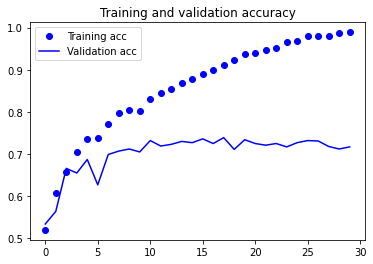

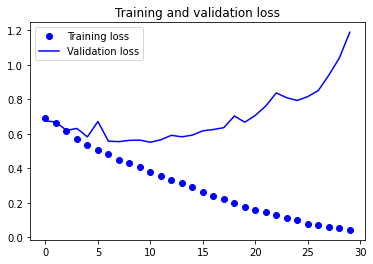

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

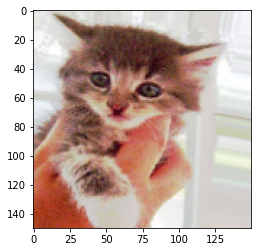

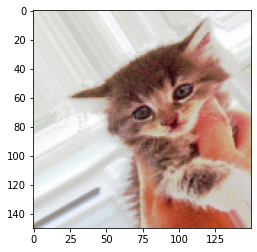

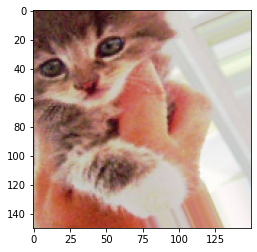

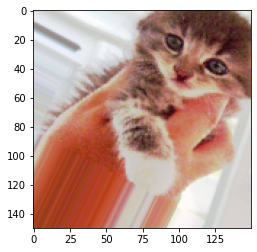

In [ ]:
# 이미지 전처리 유틸리티 모듈
from keras.preprocessing import image

fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

# 증식할 이미지 선택합니다
img_path = fnames[3]

# 이미지를 읽고 크기를 변경합니다
img = image.load_img(img_path, target_size=(150, 150))

# (150, 150, 3) 크기의 넘파이 배열로 변환합니다
x = image.img_to_array(img)

# (1, 150, 150, 3) 크기로 변환합니다
x = x.reshape((1,) + x.shape)

# flow() 메서드는 랜덤하게 변환된 이미지의 배치를 생성합니다.
# 무한 반복되기 때문에 어느 지점에서 중지해야 합니다!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=10000,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블을 만들어야 합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=50,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100


In [ ]:
model.save('cats_and_dogs_small_2.h5')

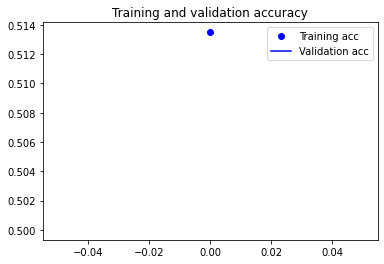

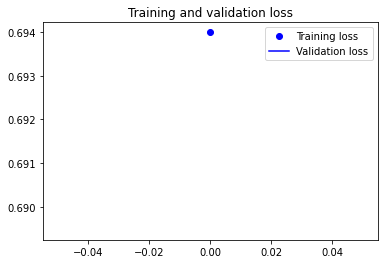

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 5.3 사전훈련된 컨브넷 사용하기
- 작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 매우 효과적인 방법은 사전 훈련된 네트워크를 사용하는 것입니다
- 학습된 특성을 다른 문제에 적용할 수 있는 이런 유연성은 이전의 많은 얕은 학습 방법과 비교했을 때 딥러닝의 핵심 장점입니다. 
-  (1.4백만 개의 레이블된 이미지와 1,000개의 클래스로 이루어진) ImageNet 데이터셋에서 훈련된 대규모 컨브넷을 사용
- VGG16 구조
    - 캐런 시몬연과 앤드류 지서먼이 2014년에 개발
    - VGG16은 간단하고 ImageNet 데이터셋에 널리 사용되는 컨브넷 구조
    - VGG16은 조금 오래되었고 최고 수준의 성능에는 못미치며 최근의 다른 모델보다는 조금 무겁
#### 5.3.1 특성 추출

- 특성 추출은 사전에 학습된 네트워크의 표현을 사용해 새로운 샘플에서 흥미로운 특성을 뽑아내는 것
- 이런 특성을 사용하여 새로운 분류기를 처음부터 훈련
- 컨브넷은 이미지 분류를 위해 두부분으로 구성
- 먼저 연속돤 합성곱과 풀링 층으로 시작해서 완전 연결 분류기로 끝남

- 모델의 합성곱 기반층(convolutional base):컨브넷의 경우 특성 추출은 사전에 훈련된 네트워크의 합성곱 기반층을 선택해 새로운 데이터를 통과시키고 그 출력으로 새로운 분류기를 훈련합니다.
- 컨브넷의 경우 특성 추출은 사전에 훈련된 네트워크의 합성곱 기반층을 선택해 새로운 데이터를 통과시키고 그 출력으로 새로운 분류기를 훈련합니다.
- 합성곱 층만 재사용 하는 이유: 합성곱 층에 의해 학습된 표현이 더 일반적이어서 재사용 가능
- 특정 합성곱 층에서 추출한 표현의 일반성(그리고 재사용성)의 수준은 모델에 있는 층의 깊이에 달려 있습니다. 
- 새로운 데이터셋이 원본 모델이 훈련한 데이터셋과 많이 다르다면 전체 합성곱 기반층을 사용하는 것보다는 모델의 하위 층 몇 개만 특성 추출에 사용하는 것이 좋습니다.
- ImageNet의 클래스 집합에는 여러 종류의 강아지와 고양이를 포함하고 있습니다.
- 원본 모델의 완전 연결 층에 있는 정보를 재사용하는 것이 도움이 될 것 같습니다. 

ImageNet 데이터셋에 훈련된 VGG16 네트워크의 합성곱 기반층을 사용하여 강아지와 고양이 이미지에서 유용한 특성을 추출해 보겠습니다. 그런 다음 이 특성으로 강아지 vs. 고양이 분류기를 훈련합니다.




In [ ]:

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # weight는 모델의 초기화할 가중치 체크포인트
                  include_top=False, #네트워크의 최상위 완전 연결 분류기를 포함여부
                  input_shape=(150, 150, 3)) # 네트워크에 주입할 이미지 텐서의 크기 ,이 값을 지정하지 않으면 네트워크가 어떤 크기의 입력도 처리 가능

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     